## Biclustering

The classical clustering methods, including k-means, hierarchical clustering, and DBSCAN, focus on one dimension (row). These algorithms essentially cluster rows (i.e., instances) based on similarities between rows. On the other hand, **biclustering algorithms** simultaneously cluster rows (i.e., instances) and columns (i.e., features) of a data matrix. This type of clustering is also known as **block clustering** or **co-clustering**. Each cluster is a submatrix of the original data matrix with some desired properties.


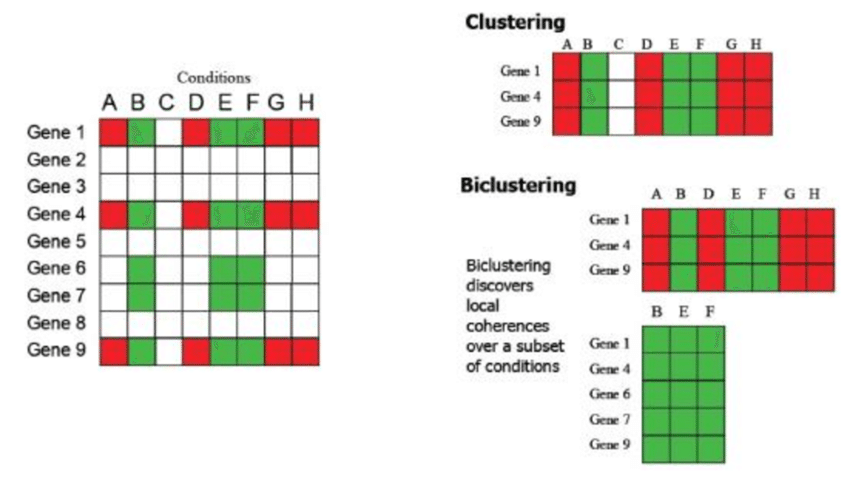
source: [Research Gate](https://www.researchgate.net/publication/319155786_Understanding_Structure_of_Poverty_Dimensions_in_East_Java_Bicluster_Approach/figures)

The above toy example shows a set of genes expressed under some conditions. The row-wise clustering method groups rows while taking all columns into account for measuring similarity measures. On the other hand, a biclustering method takes a subset of columns into account while grouping rows. We can observe that the biclustering methods may discover richer clusters. 

In [ ]:
from collections import defaultdict
import operator
from time import time

import numpy as np

from sklearn.cluster import SpectralCoclustering,SpectralBiclustering
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import v_measure_score

## Dataset 

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics. This dataset is used for classification, where features are extracted from posts and topics are class label. In this notebook, we will ignore the topics and apply biclustering method on the textual data . 


The sklearn.datasets.fetch_20newsgroups function is a data fetching / caching functions that downloads the data archive from the original 20 newsgroups website.

In [ ]:
# exclude 'comp.os.ms-windows.misc'
#The ‘comp.os.ms-windows.misc’ category is excluded because it contains many posts containing nothing.
categories = ['alt.atheism', 'comp.graphics',
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'comp.windows.x', 'misc.forsale', 'rec.autos',
              'rec.motorcycles', 'rec.sport.baseball',
              'rec.sport.hockey', 'sci.crypt', 'sci.electronics',
              'sci.med', 'sci.space', 'soc.religion.christian',
              'talk.politics.guns', 'talk.politics.mideast',
              'talk.politics.misc', 'talk.religion.misc']

newsgroups = fetch_20newsgroups(categories=categories)
y_true = newsgroups.target

## Number Normalizing Vectorizer

We convert news posts to a word frequency matrix using TF-IDF vectorizer. Each row in the resultant matrix is a post or document, and each column represents a word in the vocabulary (i.e., feature set). If we apply a biclustering method on this dataset, the resulting document-word biclusters denote subsets of words used more often in those subsets of documents.

In [ ]:
def number_normalizer(tokens):
    """ Map all numeric tokens to a placeholder.

    For many applications, tokens that begin with a number are not directly
    useful, but the fact that such a token exists can be relevant.  By applying
    this form of dimensionality reduction, some methods may perform better.
    """
    return ("#NUMBER" if token[0].isdigit() else token for token in tokens)

In [ ]:
class NumberNormalizingVectorizer(TfidfVectorizer):
    def build_tokenizer(self):
        tokenize = super().build_tokenizer()
        return lambda doc: list(number_normalizer(tokenize(doc)))

In [ ]:
# define a vectorizer

vectorizer = NumberNormalizingVectorizer(stop_words='english', min_df=5, max_features=200)

# min_df = 5: a word must occur at least 5 times in order to be included in the feature list
# max_features=100: return top 100 features

X = vectorizer.fit_transform(newsgroups.data)

Now, we inspect first few rows in this TFIDF matrix. 

In [ ]:
import pandas as pd

df = pd.DataFrame.sparse.from_spmatrix(X, columns = vectorizer.get_feature_names())
df.head()

In [ ]:
df.shape

## Spectral CoClustering

The spectral coclustering algorithm **finds biclusters with values higher than those in the corresponding other rows and columns**. Each row and column belongs to exactly one bicluster, so rearranging the rows and columns to make partitions contiguous reveals these high values along the diagonal. A typical output of spectral coclustering methods is shown below. 

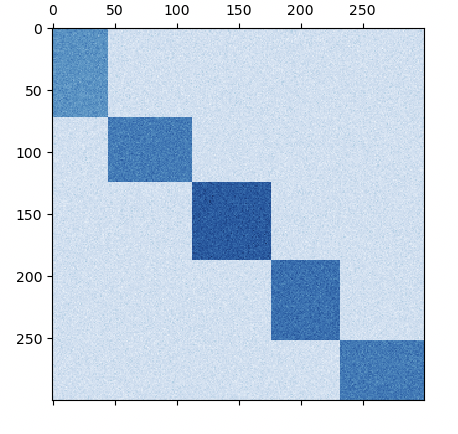

**Note**: The algorithm treats the input data matrix as a bipartite graph: the rows and columns of the matrix correspond to the two sets of vertices, and each entry corresponds to an edge between a row and a column. The algorithm approximates the normalized cut of this graph to find heavy subgraphs.

### Define and fit a SpectralCoclustering model

In [ ]:
cocluster = SpectralCoclustering(n_clusters=len(categories),
                                 svd_method='arpack', random_state=0)

# here, we set n_clusters=len(categories) for the sake of comparison. 
# In real-world this parameter would be unkown to us most of the time.
# Remember how we use elbow method to choose the right number of clusters


In [ ]:
cocluster.fit(X)

Let's print the cluster labels for the first 10 rows. 

In [ ]:
y_cocluster = cocluster.row_labels_
print(len(y_cocluster))
print(y_cocluster[:10])

Each row or column should belong one cluster. How to verify that?

In [ ]:
cocluster.biclusters_[0].shape  
# The indicators for cluster membership of each row.; in this case 19 clusters and ~10K rows

In [ ]:
cocluster.biclusters_[1].shape
# The indicators for cluster membership of each column; in this case 19 clusters and ~200 features

Let's see the number of clusters assigned to each column. From the following output, we can confirm each column belongs to only one cluster. 

In [ ]:
temp = cocluster.biclusters_[1].sum(axis=0)
temp

In [ ]:
(temp > 1).sum()

Now we count the number clusters per row. From the following output, we can confirm each row belongs to only one cluster.

In [ ]:
temp = cocluster.biclusters_[0].sum(axis=0)
(temp > 1).sum()

### Evaluation 

There are some measures that are developed to evaluate biclustering methods. E.g., scikit learn provide [consensus_scores](https://scikit-learn.org/stable/modules/biclustering.html#biclustering-evaluation).  Using this method, we can compare the inferred biclusters with some random biclusters and derive a score (higher is better). 

In [ ]:
set(y_cocluster)

Since this newsgroup dataset provides true class labels, we can take advantage of these classes. We can use [V-measure](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html#sklearn.metrics.v_measure_score) to evaluate these biclusters (perfect match =1, no match=0). We will only focus on row-level clusters so that we can compare with k-means. 

In [ ]:
### Evaluation
v_score = v_measure_score(y_cocluster, y_true)
print(f"V-measure: {v_score:.4f}")

Now, we compare against a k-Means method. 

In [ ]:
kmeans = KMeans(n_clusters=len(categories), random_state=0)

In [ ]:
y_kmeans = kmeans.fit_predict(X)
v_score = v_measure_score(y_kmeans, y_true)
print(f"V-measure: {v_score:.4f}")

There are other ways to evluate biclusters. E.g., using the notion of **normalized graph cut**, which measure overall similarity withing a cluster and dissimilarty of the cluster with other clusters. Here, the lower the normalized score, the better. 

In [ ]:
feature_names = vectorizer.get_feature_names()
document_names = list(newsgroups.target_names[i] for i in newsgroups.target)

In [ ]:
# This function estimate normalized cut scores for each biclusters

def bicluster_ncut(i):
    rows, cols = cocluster.get_indices(i)  # get the row and col indices of cluster i
    
    if not (np.any(rows) and np.any(cols)):
        import sys
        return sys.float_info.max
    
    #  # get the row and col indices that do not belong to cluster i
    row_complement = np.nonzero(np.logical_not(cocluster.rows_[i]))[0]
    col_complement = np.nonzero(np.logical_not(cocluster.columns_[i]))[0]
    
    
    weight = X[rows][:, cols].sum()  # total weights of cluster i
    
    cut = (X[row_complement][:, cols].sum() +
           X[rows][:, col_complement].sum())   
    # total weights of the matrix subset with these rows and cols except the cluster portion
    
    return cut / weight


def most_common(d):
    """Items of a defaultdict(int) with the highest values.

    Like Counter.most_common in Python >=2.7.
    """
    return sorted(d.items(), key=operator.itemgetter(1), reverse=True)


In [ ]:
bicluster_ncuts = list(bicluster_ncut(i)
                       for i in range(len(newsgroups.target_names)))
bicluster_ncuts

Let's inspect the first 10 biclusters in terms of normalized cut scores. 

In [ ]:
best_idx = np.argsort(bicluster_ncuts)[:10]
best_idx

In [ ]:
print()
print("Best biclusters:")
print("----------------")


for idx, cluster in enumerate(best_idx):
    n_rows, n_cols = cocluster.get_shape(cluster)
    cluster_docs, cluster_words = cocluster.get_indices(cluster)
    if not len(cluster_docs) or not len(cluster_words):
        continue

    # categories
    counter = defaultdict(int)
    for i in cluster_docs:
        counter[document_names[i]] += 1
    cat_string = ", ".join("{:.0f}% {}".format(float(c) / n_rows * 100, name)
                           for name, c in most_common(counter)[:3])

    # words
    out_of_cluster_docs = cocluster.row_labels_ != cluster
    out_of_cluster_docs = np.where(out_of_cluster_docs)[0]
    word_col = X[:, cluster_words]
    word_scores = np.array(word_col[cluster_docs, :].sum(axis=0) -
                           word_col[out_of_cluster_docs, :].sum(axis=0))
    word_scores = word_scores.ravel()
    important_words = list(feature_names[cluster_words[i]]
                           for i in word_scores.argsort()[:-11:-1])

    print("bicluster {} : {} documents, {} words".format(
        idx, n_rows, n_cols))
    print("categories   : {}".format(cat_string))
    print("words        : {}\n".format(', '.join(important_words)))

For most of the biclusters, the mixture of topics/categories as well as the captured important words make sense. 

## Spectral Biclustering

The **spectral biclustering** algorithm assumes that the input data matrix has a hidden checkerboard structure (see the fig below). The rows and columns of a matrix with this structure may be partitioned so that the entries of any bicluster in the Cartesian product of row clusters and column clusters are approximately constant. The algorithm partitions the rows and columns of a matrix so that a corresponding blockwise-constant checkerboard matrix provides a good approximation to the original matrix. For instance, if there are 4 row partitions and 3 column partitions, each row will belong to 3 biclusters, and each column will belong to 4 biclusters (see the fig below).

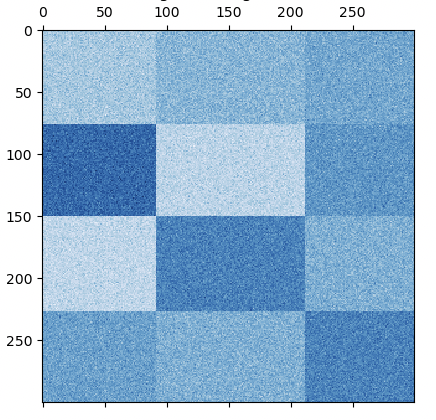



### Define and fit a SpectralBiclustering model

In [ ]:
bicluster = SpectralBiclustering(n_clusters=len(categories),
                                 svd_method='arpack', random_state=0)

In [ ]:
bicluster.fit(X)

In [ ]:
bicluster.biclusters_[0].shape  

In [ ]:
bicluster.biclusters_[1].shape

Unlike coclustering, here each row belongs to all of the clusters. That's why 19 x 19 = 361 entries (19 1-hot encoding) are used to capture cluster assignements. 

In [ ]:
temp = bicluster.biclusters_[0].sum(axis=0)
(temp > 1).sum()

In [ ]:
temp = bicluster.biclusters_[1].sum(axis=0)
(temp > 1).sum()

### Evaluation

Let's measure V-score. 

In [ ]:
y_bicluster = bicluster.row_labels_

v_score = v_measure_score(y_bicluster, y_true)
print(f"V-measure: {v_score:.4f}")

The V-score for spectral biclustering method is lower than the K-means. So we can conclude that this is not a good fit based on clustering over rows. 